# <center><font color=	DarkRed>Construire un modèle de scoring</font></center><br>
# <center><font color=	DarkRed>Analyse exploratoire du jeu de données</font></center><br>

<center>
<img src="../images/pret-a-depenser.png", style="width:250px">
</center>

<center>
La société financière <font color=DarkGreen><b>Prêt à dépenser</b></font> propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.</center>  

<center>Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de <font color=DarkGreen><b>scoring crédit</b></font> qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : <font color=DarkGreen><b>crédit accordé ou refusé</b></font>.
</center>

<hr>

**<font color=DarkRed>La mission</font>** est de créer un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. à l'aide d'un algorithme de classification qui va aider l'entreprise à décider si un prêt peut être accordée à un client.

**<font color=DarkRed>L'environnement de développement</font>** a été installé via la distribution <code>**Anaconda**</code>, intégrant en natif :
- le langage de programmation <code>**Python**</code>, adapté pour l'analyse de données,
- le <code>**Jupyter Notebook**</code>, qui permet de rassembler dans un même document du texte, des images et du code informatique exécutable et manipulable dans un navigateur web .<br>

J'ai créé un **environnement virtuel** dédié à ce projet dans <code>**Anaconda**</code> pour assurer l'isolement du projet et la gestion des dépendances.

**<font color=DarkRed>La méthodologie :</font>** 
- **Développer un algorithme de classification supervisée** (***supervisée** = les données sont labellisés **(étiquetés ou annotés)***) :

    - **0 (sera rembourser)** = ACCORDE;
    - **1 (ne sera pas rembourser)** = REFUSER;
    
La métrique attendue, est la prédiction d'une probabilité de défaut de paiement comprise entre **0 % (pas de risque) et 100 % (risque maximal)**.

---

#### Utilisation de kernels Kaggle

Pour aller plus vite sur la préparation des données . 

Je vais utiliser un kernel Kaggle pour cette étape.
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

---



<hr>

La première étape consiste en l'**importation des librairies <code>Python</code>** nécessaires à l'analyse dans le <code>**Jupyter Notebook**</code> : <br>
- <code>**NumPy**</code>, 
- <code>**Pandas**</code>, 
- <code>**Matplotlib**</code>, 
- <code>**Seaborn**</code>, 
- <code>**Missingno**</code>,
- <code>**Sklearn**</code>.

## Importation des librairies

In [ ]:
# Pour la gestion de l'utilisation de la mémoire
import gc

# Gestion du système de fichiers
import os

# Pour la manipulation de données
import numpy as np # algèbre linéaire
import pandas as pd # data processing, CSV file I/O

# Pour la visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# Visualisation des valeurs manquante
import missingno as msno

# sklearn preprocessing pour traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Pour la gestion des alertes
import warnings 
from warnings import simplefilter
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


# Import des modules contenant les fonctions utilitaires
#import src.my_module.data_helpers as dth

## Declaration des fonctions

#### Fonction pour la réduction usage mémoire

In [ ]:
# Fonction pour réduire l'usage de la mémoire par des formats de données trop gourmands 
def reduce_mem_usage(df_):
    start_mem = df_.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for c in df_.columns[df_.dtypes != 'object']:
        col_type = df_[c].dtype
        
        c_min = df_[c].min()
        c_max = df_[c].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df_[c] = df_[c].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df_[c] = df_[c].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df_[c] = df_[c].astype(np.int32)
            else:
                df_[c] = df_[c].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df_[c] = df_[c].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df_[c] = df_[c].astype(np.float32)
            else:
                df_[c] = df_[c].astype(np.float64)

    end_mem = df_.memory_usage().sum() / 1024**2
    print('Utilisation de la mémoire après optimisation: {:.2f} MB'.format(end_mem))
    print('Diminué de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    



### Fonction pour EDA

In [ ]:
def taux_remplissage(df, min_threshold,label_min_threshold,max_threshold,label_max_threshold):
    """
    Cette fonction permet d'afficher le taux de remplissage du dataset avec un graphique en barreshorizontale
    avec pour abscisses la liste des variables
    et pour ordonnées le taux de remplissage en pourcentage
    
    Arguments : dataframe, le seuil minimum , le seuil maximum, 
    Résultat : Diagramme en bar horizontale avec le % du taux de remplissage avec affichage du seuil renseignée
    """
# Calcul du taux de remplissage des colonnes
    rate = pd.DataFrame(
        df.count()/df.shape[0]*100,
        columns=["Taux de remplissage"]).sort_values("Taux de remplissage", 
                                                 ascending=False).reset_index()

    # Plot
    fig, axs = plt.subplots(figsize=(10,35))
    sns.barplot(y=rate["index"], x="Taux de remplissage", 
                data=rate, palette="rainbow_r")# Permuter x et y change le sens du graph
    plt.title("Taux de remplissage des variables", fontsize=14)
    plt.xlabel("Taux de remplissage (%)")
    plt.ylabel("")
    plt.axvline(x=min_threshold, color='g')
    plt.text(min_threshold, -1, label_min_threshold, color='g', fontsize=14)
    plt.axvline(x=max_threshold, color='r')
    plt.text(max_threshold, -1, label_max_threshold, color='r', fontsize=14)
    return plt.show()

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Le Dataframe à " + str(df.shape[1]) + " colonness.\n"      
            "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes qui ont des valeurs manquantes.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
# Pour explorer les valeurs manquantes dans les ensembles d'entraînement et de test
def get_missing_report(df_, target_name = 'TARGET'):
    # Divide in training/validation and test data
    df_train_ = df_[df_[target_name].notnull()].drop(target_name, axis = 1)
    df_test_ = df_[df_[target_name].isnull()].drop(target_name, axis = 1)
    
    count_missing_train = df_train_.isnull().sum().values
    ratio_missing_train = count_missing_train / df_train_.shape[0]
    count_missing_test = df_test_.isnull().sum().values
    ratio_missing_test = count_missing_test / df_test_.shape[0]
    
    return pd.DataFrame(data = {'count_missing_train': count_missing_train, 
                                'ratio_missing_train': ratio_missing_train,
                                'count_missing_test': count_missing_test, 
                                'ratio_missing_test': ratio_missing_test}, 
                        index = df_test_.columns.values)


# Pour comparer les distributions de deux caractéristiques
from scipy.stats import ranksums
def corr_feature_with_target(feature, target):
    c0 = feature[target == 0].dropna()
    c1 = feature[target == 1].dropna()
        
    if set(feature.unique()) == set([0, 1]):
        diff = abs(c0.mean(axis = 0) - c1.mean(axis = 0))
    else:
        diff = abs(c0.median(axis = 0) - c1.median(axis = 0))
        
    p = ranksums(c0, c1)[1] if ((len(c0) >= 20) & (len(c1) >= 20)) else 2
        
    return [diff / feature.mean(), p]



## <center><font color=darkRed>1. - Présentation générale du jeu de données</font></center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Affichage de la liste des différents fichiers
# Charger le jeu de données global
print("Liste des fichiers :")
for file in os.listdir("/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/"):
    if file.endswith(".csv"):
        print("- " + file)

Liste des fichiers :
- HomeCredit_columns_description.csv
- credit_card_balance.csv
- bureau_balance.csv
- POS_CASH_balance.csv
- application_test.csv
- bureau.csv
- sample_submission.csv
- installments_payments.csv
- previous_application.csv
- application_train.csv
- df_train_poly.csv
- df_test_poly.csv
- df_train.csv
- df_test.csv


In [ ]:
# Charger le jeu d'entrainement
df_train = pd.read_csv("/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/application_train.csv")

# Charger le jeu de test
df_test = pd.read_csv("/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/application_test.csv")


print("Train : {}, Test : {}".format(df_train.shape, df_test.shape))
print("Train % : {}, Test % : {}".format(round(100 * len(df_train) /(len(df_train)+len(df_test)), 0), 
                                         round(100 * len(df_test) / (len(df_train)+len(df_test)), 0)))

Train : (307511, 122), Test : (48744, 121)
Train % : 86.0, Test % : 14.0


In [ ]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Le jeu de données ***application_train.csv*** donne des informations suivantes :

- **Données personnelles du demandeur** : sexe, âge au moment de la demande, situation familiale, nombre d'enfants, profession, revenus, niveau d'études, informations sur le lieu de résidence, fournitures (voiture, maison, téléphone, etc.);
- **Données liées au crédit** : identifiant unique, type de crédit, montant du crédit, montant de la rente, documents fournis, etc;
- **Informations externes (scores)** : les institutions financières semblent pouvoir acheter des scores pour déterminer les profils de crédit, mais n'ont aucun moyen de savoir comment ces scores ont été créés; 
- **Variable cible** : "TARGET".

Je vais fusionner les deux dataset pour ensuite effectuer un nettoyage et créer de nouvelles features. Je séparerais par la suite le dataset correctement pour l'entraînement des différents modèles, car :

- Le fichier ***application_train.csv*** **contient la colonne TARGET**, qui est la valeur que j'essaye de prédire, alors que le fichier ***application_test.csv*** quand à lui **ne contient pas cette colonne TARGET.**

Avant de fusionner les 2 fichiers (train et test), je vais effectuer différents traitements, et  analyser les différentes variables du jeu de données d'entraînement.

La variable **TARGET** est celle que notre modèle doit prédire

**TARGET = 1** correspond à un prêt non remboursé;   
**TARGET = 0** correspond à un prêt remboursé.

In [ ]:
df_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

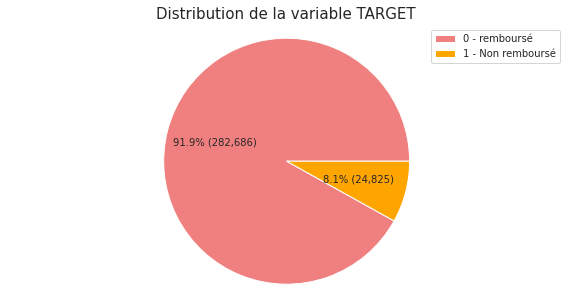

In [ ]:
# Représenter graphiquement la variable TARGET: diagramme en secteurs
plt.figure(figsize=(10,5))
values = df_train["TARGET"].value_counts()
colors = ["lightcoral", "orange"]
labels = ["0 - remboursé", "1 - Non remboursé"]
plt.pie(values,colors=colors, autopct=lambda p: "{:.1f}% ({:,.0f})".format(p, p *sum(values)/100))
plt.title("Distribution de la variable TARGET", fontsize=15)
plt.legend(labels)
plt.ylabel("")
plt.axis("equal")
plt.show()

Nous traitons ici d'un problème de **classification binaire**, avec un **ensemble d'apprentissage déséquilibré**.   
Il y a plus de prêts remboursés que de prêts non remboursés. **(92% du prêt remboursé)**  

Avant de former un **modèle supervisé**, il est nécessaire de : 
- **rééquilibrer le jeu de données** pour obtenir le même nombre de classes cibles.
- choisir une **métrique d'évaluation appropriée** : *Par exemple, <br>lorsque les données sont déséquilibrées, la métrique de précision <font color=DarkRed>(accuracy)</font> n'est pas appropriée.</br>*

## <center><font color=darkRed>2 - nettoyage des données </font></center>

### <center><font color=DarkBlue>2.1 -  Ajout de nouvelles features (fichier historique de pret)</font></center>
Je vais ajouter les données du fichier **<code>bureau.csv</code>** afin d'ajouter de **nouvelles features** qui peuvent **avoir un impact sur la modélisation**.

In [ ]:
# Charger le jeu d'entrainement
bureau = pd.read_csv("/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/bureau.csv")
bureau_balance = pd.read_csv("/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/bureau_balance.csv")

In [ ]:
#Nombre total de crédits précédents pris par chaque client
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [ ]:
# Fusionner cette nouvelle colonne avec df_train et df_test
df_train = df_train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
df_test = df_test.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
print("Train : {}, Test : {}".format(df_train.shape, df_test.shape))


Train : (307511, 123), Test : (48744, 122)


In [ ]:
#Soldes moyens mensuels des crédits précédents dans le dataset bureau balance
bureau_bal_mean = bureau_balance.groupby('SK_ID_BUREAU', as_index=False).mean().rename(columns = 
                                        {'MONTHS_BALANCE': 'MONTHS_BALANCE_MEAN'})
bureau_bal_mean = (bureau_bal_mean/-365)
bureau_bal_mean.head()

,SK_ID_BUREAU,MONTHS_BALANCE_MEAN
0,-13703.312329,0.131507
1,-13703.315068,0.112329
2,-13703.317808,0.004110
3,-13703.320548,0.024658
4,-13703.323288,0.028767


In [ ]:
bureau_full = bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
bureau_full.head()
bureau_full.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


(1716428, 17)

In [ ]:
bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_')
bureau_mean = bureau_mean.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean.shape

(305811, 14)

In [ ]:
#Merge all this features with our data sample
df_train = df_train.merge(bureau_mean, on='SK_ID_CURR', how='left')
df_test = df_test.merge(bureau_mean, on='SK_ID_CURR', how='left')

print("Train : {}, Test : {}".format(df_train.shape, df_test.shape))

Train : (307511, 136), Test : (48744, 135)


### <center><font color=DarkBlue>2.1 - Types des colonnes</font></center>
Je vais regarder le type des colonnes et de quoi elles sont composées.

In [ ]:
df_train.dtypes.value_counts()

float64    79
int64      41
object     16
dtype: int64

**<center>Synthèse du types de colonnes</center>**

| **Indicateurs** | **Valeurs** |
| :--- | :---: |
| **Variables catégorielle** | 16 |
| **Variable numérique *(int)*** | 41  |
| **Variable numerique *(flottant)*** | 79 |

In [ ]:
# Variable catégorielle
df_object_infos = df_train.select_dtypes("object").describe().T
df_object_infos["unique"] = df_train.select_dtypes("object").apply( pd.Series.unique, axis=0)
df_object_infos["nunique"] = df_train.select_dtypes("object").apply( pd.Series.nunique, axis=0)
df_object_infos

,count,unique,top,freq,nunique
NAME_CONTRACT_TYPE,307511,"[Cash loans, Revolving loans]",Cash loans,278232,2
CODE_GENDER,307511,"[M, F, XNA]",F,202448,3
FLAG_OWN_CAR,307511,"[N, Y]",N,202924,2
FLAG_OWN_REALTY,307511,"[Y, N]",Y,213312,2
NAME_TYPE_SUITE,306219,"[Unaccompanied, Family, Spouse, partner, Child...",Unaccompanied,248526,7
NAME_INCOME_TYPE,307511,"[Working, State servant, Commercial associate,...",Working,158774,8
NAME_EDUCATION_TYPE,307511,"[Secondary / secondary special, Higher educati...",Secondary / secondary special,218391,5
NAME_FAMILY_STATUS,307511,"[Single / not married, Married, Civil marriage...",Married,196432,6
NAME_HOUSING_TYPE,307511,"[House / apartment, Rented apartment, With par...",House / apartment,272868,6
OCCUPATION_TYPE,211120,"[Laborers, Core staff, Accountants, Managers, ...",Laborers,55186,18


In [ ]:
# Variable int
df_int_infos = pd.DataFrame(df_train.select_dtypes("int64").apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
df_int_infos["valeur unique"] = df_train.select_dtypes("int64").apply(pd.Series.unique,axis=0)
df_int_infos.sort_values(by="Nombre de valeur unique")

,Nombre de valeur unique,valeur unique
LIVE_CITY_NOT_WORK_CITY,2,"[0, 1]"
FLAG_DOCUMENT_3,2,"[1, 0]"
FLAG_DOCUMENT_4,2,"[0, 1]"
FLAG_DOCUMENT_5,2,"[0, 1]"
FLAG_DOCUMENT_6,2,"[0, 1]"
FLAG_DOCUMENT_7,2,"[0, 1]"
FLAG_DOCUMENT_8,2,"[0, 1]"
FLAG_DOCUMENT_9,2,"[0, 1]"
FLAG_DOCUMENT_10,2,"[0, 1]"
FLAG_DOCUMENT_11,2,"[0, 1]"


In [ ]:
# Variable float
df_float_infos = pd.DataFrame(df_train.select_dtypes("float64").apply(pd.Series.nunique,axis=0),columns=["Nombre de valeur unique"])
df_float_infos["valeur unique"] = df_train.select_dtypes("float64").apply(pd.Series.unique,axis=0)
df_float_infos.sort_values(by="Nombre de valeur unique")

,Nombre de valeur unique,valeur unique
PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,0,[nan]
AMT_REQ_CREDIT_BUREAU_HOUR,5,"[0.0, nan, 1.0, 2.0, 3.0, 4.0]"
AMT_REQ_CREDIT_BUREAU_DAY,9,"[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 9.0, ..."
AMT_REQ_CREDIT_BUREAU_WEEK,9,"[0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, ..."
DEF_60_CNT_SOCIAL_CIRCLE,9,"[2.0, 0.0, 1.0, nan, 3.0, 5.0, 4.0, 7.0, 24.0,..."
...,...,...
PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,97903,"[-349.0, -544.5, -488.5, nan, -783.0, -391.333..."
EXT_SOURCE_1,114584,"[0.0830369673913225, 0.3112673113812225, nan, ..."
EXT_SOURCE_2,119831,"[0.2629485927471776, 0.6222457752555098, 0.555..."
PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,169333,"[49156.2, 0.0, nan, 80019.0, 76953.53571428571..."


### <center><font color=DarkBlue>2.2 - Valeur manquantes</font></center>

Je vais examiner le nombre de valeurs manquantes pour chaque colonne.

In [ ]:
missing_val = missing_values_table(df_train)
missing_val

Le Dataframe à 136 colonness.
Il y a 81 colonnes qui ont des valeurs manquantes.


,Missing Values,% of Total Values
PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,307511,100.0
PREV_BUR_MEAN_AMT_ANNUITY,227502,74.0
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


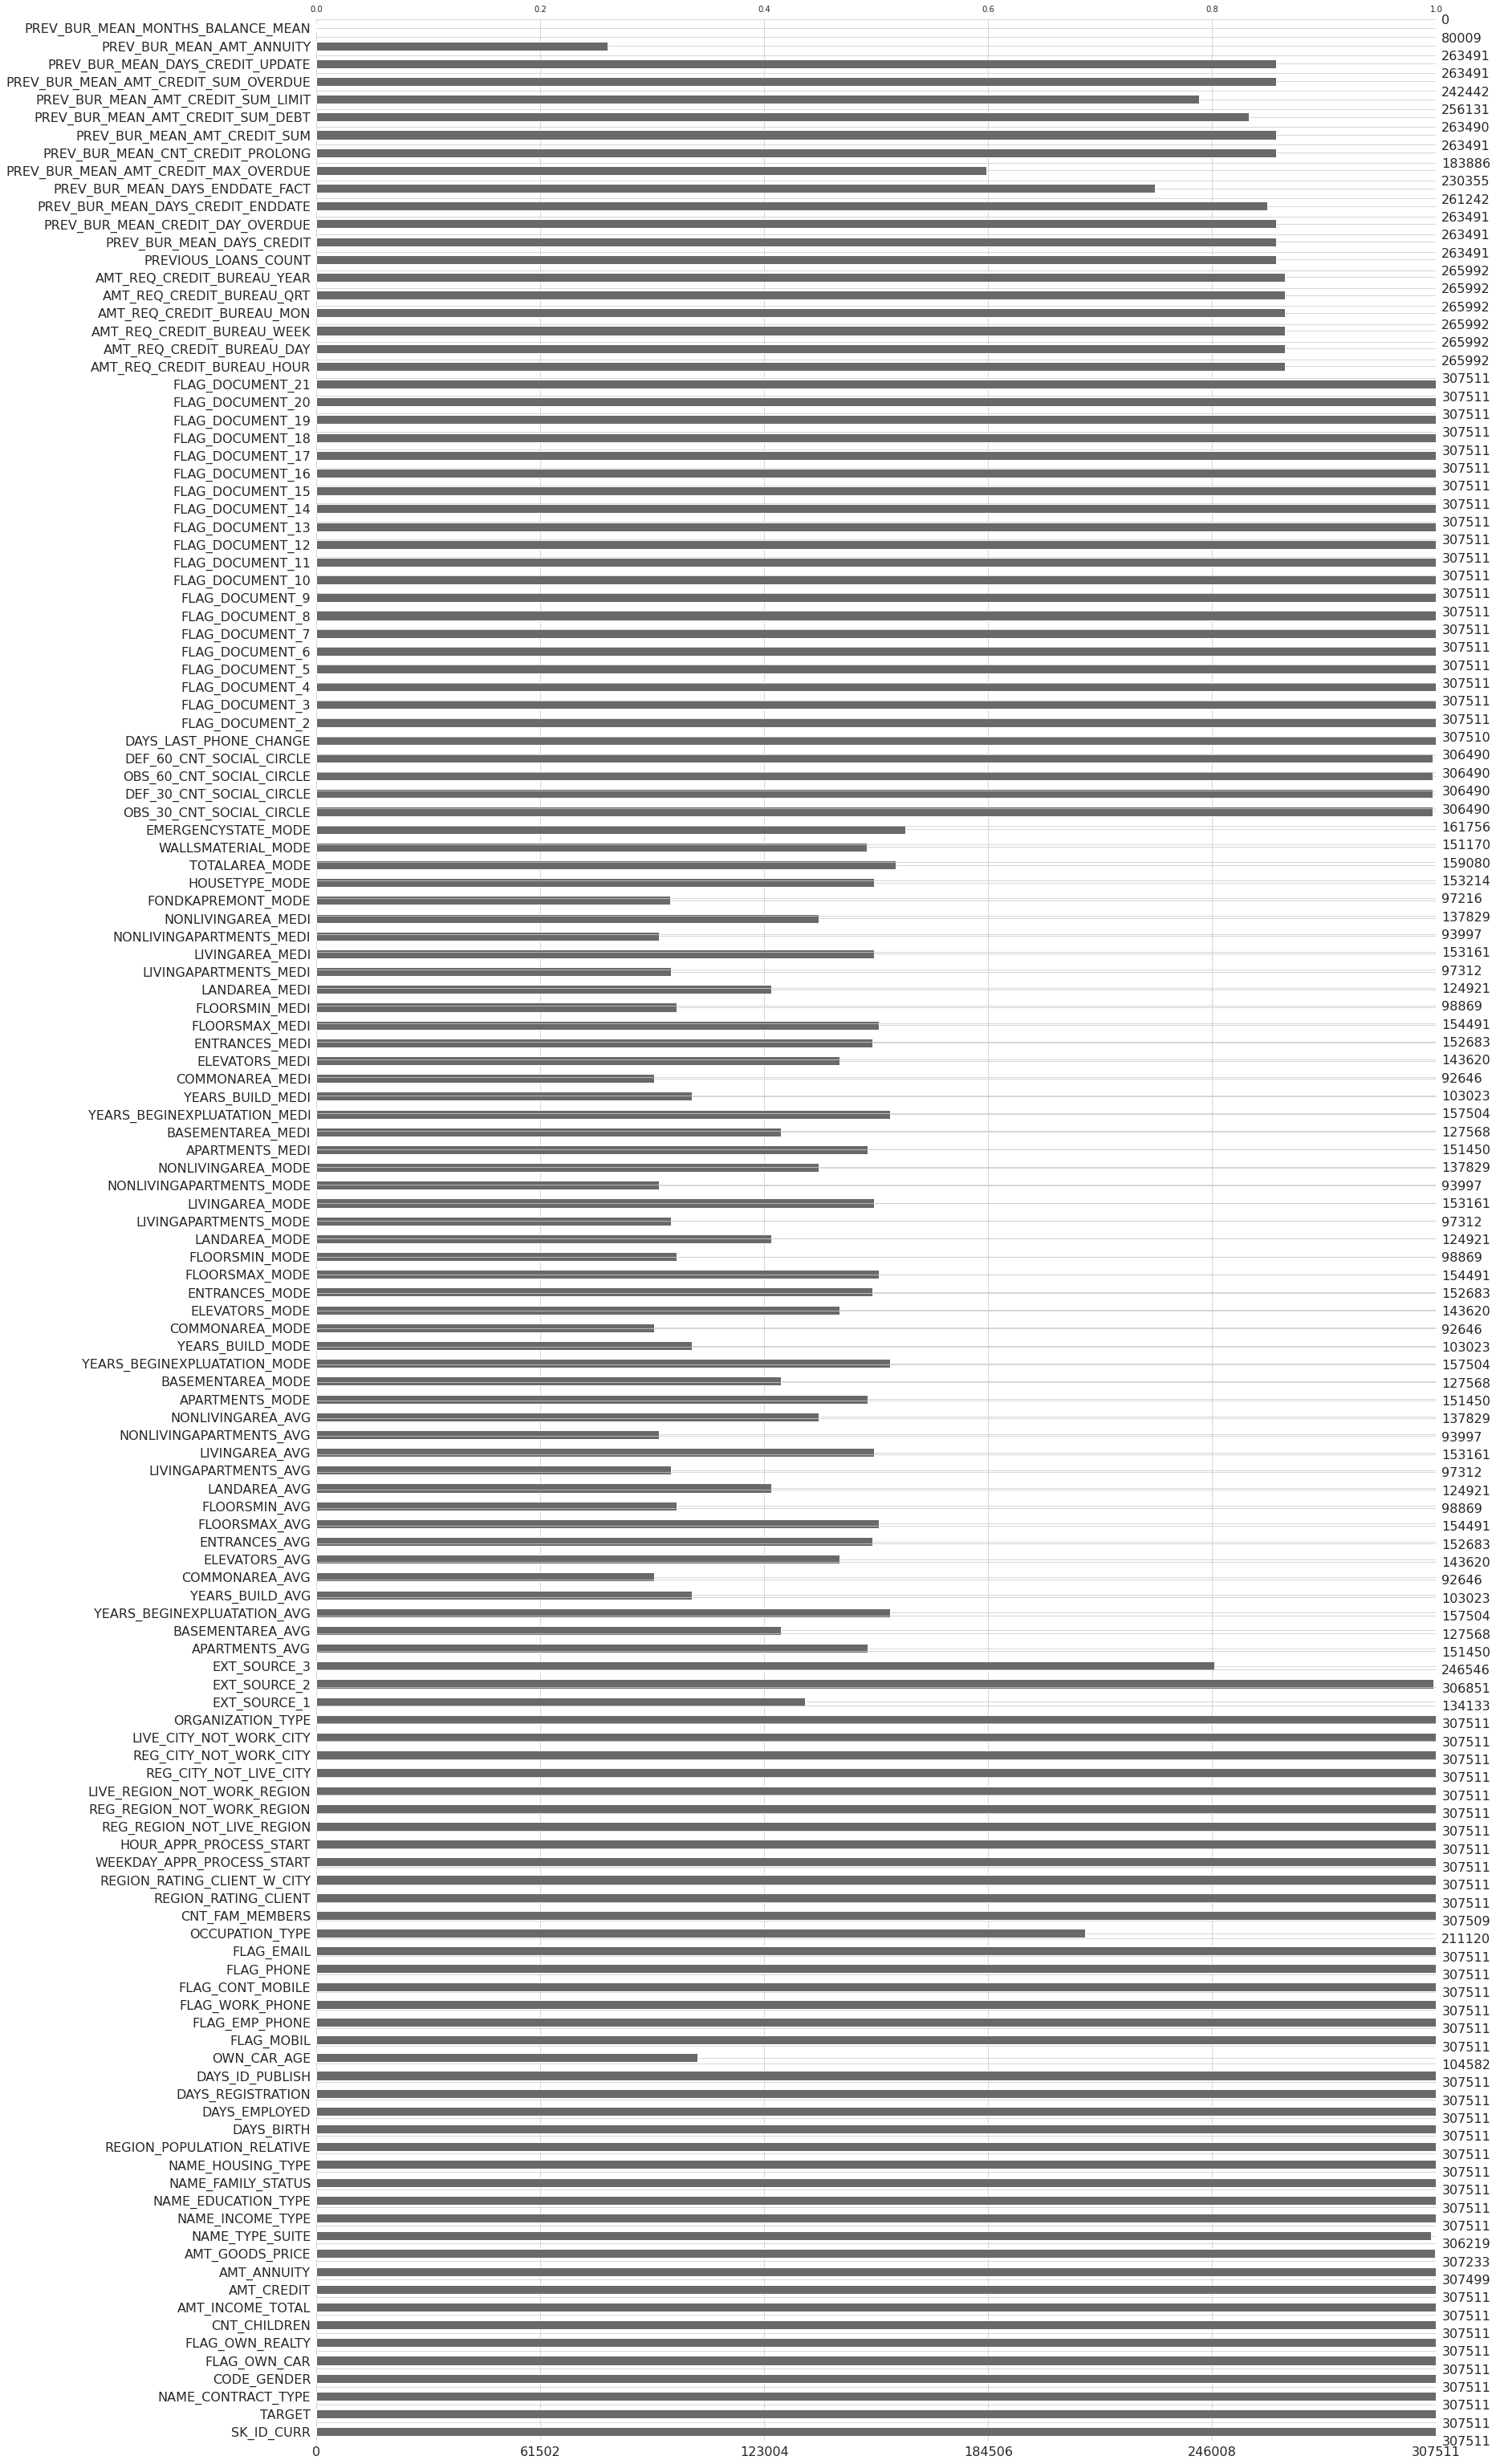

In [ ]:
msno.bar(df_train)

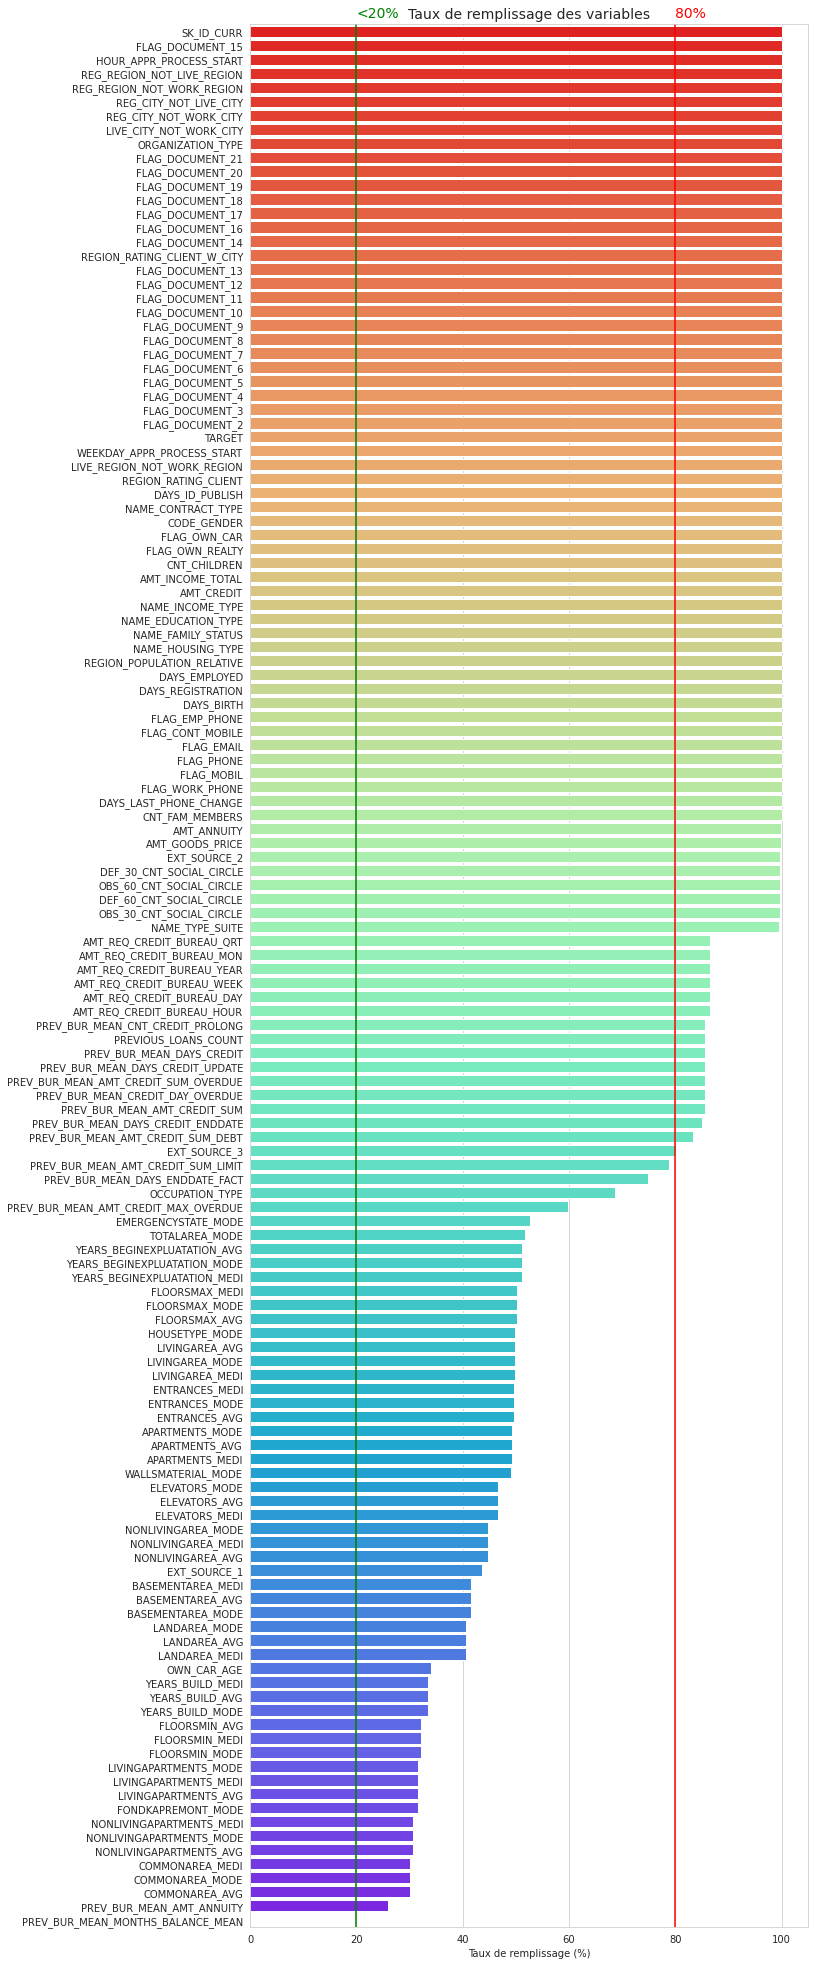

In [ ]:
taux_remplissage(df_train, 20,'<20%', 80,"80%")

Je supprime les colonnes qui ont plus de 60% de valeurs manquantes.

In [ ]:
seuil = 60
indexNames = missing_val[(missing_val['% of Total Values'] >= seuil)].index
df_train.drop(indexNames , axis=1,inplace=True)
df_test.drop(indexNames ,axis=1, inplace=True)
print("Train :", df_train.shape, "Test :", df_test.shape)

Train : (307511, 117) Test : (48744, 116)


### <center><font color=DarkBlue>2.3 - Valeurs aberrantes</font></center>
Je vais regarder les variables qui présentent des anomalies.

#### DAYS_BIRTH (Âge) 
La variable <code>DAYS_BIRTH</code> rapporte les jours de la demande de prêt en cours, ce qui est incompréhensible dans son format actuel. 
Je divise donc par -365 pour mieux la comprendre.

In [ ]:
(df_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Text(0.5, 1.0, 'DAYS_BIRTH')

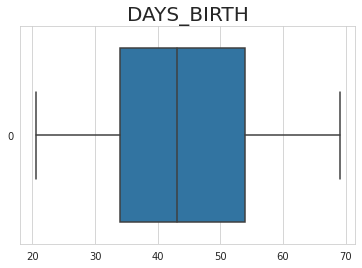

In [ ]:
# DAYS_EMPLOYED  
data = df_train['DAYS_BIRTH'] / -365
ax=sns.boxplot(data=abs(data), orient="h")
Titre = 'DAYS_BIRTH'
plt.title(Titre,fontsize=20)

Text(0, 0.5, 'frequence')

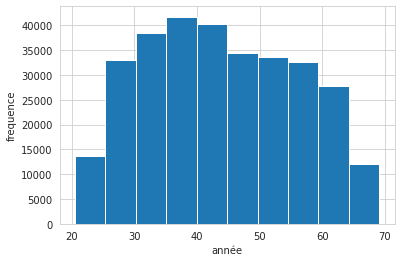

In [ ]:
(df_train['DAYS_BIRTH']/-365).hist()
plt.xlabel('année')
plt.ylabel('frequence')

**<center><font color=DarkRed>L'âge moyen du demandeur est de 43 ans, le minimum est de 20 ans et le maximum est de 69 ans, ce qui est logique</font></center>**

#### DAYS_EMPLOYED (Antécédents professionnels)

Pour les journées travaillées, on voit que le maximum n'a définitivement pas de sens puisqu'il est de +1000 ans ! 
Les valeurs sont négative (cela peut être liée à une faute de frappe)

In [ ]:
# Afficher les statistiques de base 
#j'affiche les valeur de ma variable en divisant par le nombre de jours dans une année les valeurs etant negative, je divise par -365)
(df_train['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 1.0, 'DAYS_EMPLOYED')

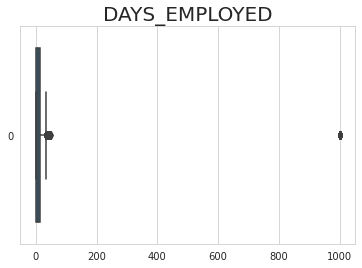

In [ ]:
# DAYS_EMPLOYED  
data = df_train['DAYS_EMPLOYED']/-365
ax=sns.boxplot(data=abs(data), orient="h")
#ax.set_xscale('log')
Titre = 'DAYS_EMPLOYED'
plt.title(Titre,fontsize=20)

La variable <code>DAYS_EMPLOYED</code> présente des valeurs extrêmes (1000 ans) que je vais remplacer par NaN.

In [ ]:
# Remplacer la valeur extrême par NaN
df_train["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
df_test["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

# Afficher les statistiques de base
(df_train["DAYS_EMPLOYED"]/-365).describe()

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

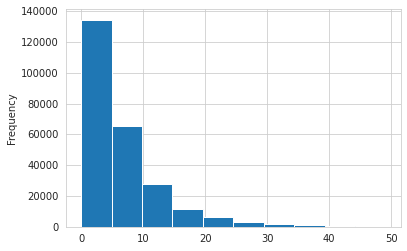

In [ ]:
(df_train['DAYS_EMPLOYED'] / -365).plot.hist();

Text(0.5, 1.0, "Répartition de l'emploi pour défaut et non défaut de paiement")

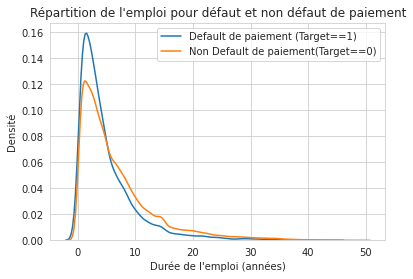

In [ ]:
dflt_daysEmp = df_train.loc[df_train['TARGET']==1,'DAYS_EMPLOYED'] 
nonDflt_daysEmp = df_train.loc[df_train['TARGET']==0,'DAYS_EMPLOYED'] 

sns.kdeplot(dflt_daysEmp/-365,label='Default de paiement (Target==1)')
sns.kdeplot(nonDflt_daysEmp/-365,label='Non Default de paiement(Target==0)')
plt.legend()
plt.xlabel("Durée de l'emploi (années)")
plt.ylabel('Densité')
plt.title("Répartition de l'emploi pour défaut et non défaut de paiement")

Nous pouvons voir que moins vous avez été employé, plus il y a de risque de defaut de paiement.

#### Controle des valeurs unique sur le TRAIN et le TEST

Je vais contrôler que les valeurs uniques sur le dataset TRAIN et le TEST soit identique, si cela n'est pas le cas, je supprimerais les valeurs.


In [ ]:
# Contrôler les différences de valeurs uniques de chaque variable catégorielle des 2 dataframes
for col in df_train.columns[df_train.dtypes == "object"]:
    col_train = set(df_train[col].unique())
    col_test = set(df_test[col].unique())
    diff = col_train ^ col_test
    if len(diff) > 0 :
        print("La variable " + col + " a des étiquettes différentes: ", diff)

La variable CODE_GENDER a des étiquettes différentes:  {'XNA'}
La variable NAME_INCOME_TYPE a des étiquettes différentes:  {'Maternity leave'}
La variable NAME_FAMILY_STATUS a des étiquettes différentes:  {'Unknown'}


In [ ]:
df_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

Pour le genre des personnes, on voit qu'il y a plus de femmes que d'hommes et qu'il y a 4 personnes dont le genre n'est pas renseigné.

Il y a 3 variables pour lesquelles les valeurs sont différentes dans le dataset de train et de test, je vais donc les exclure.

In [ ]:
df_train = df_train[df_train["CODE_GENDER"] != "XNA"]
df_train = df_train[df_train["NAME_INCOME_TYPE"] != "Maternity leave"]
df_train = df_train[df_train["NAME_FAMILY_STATUS"] != "Unknown"]

## <center><font color=DarkRed>3 - Feature engineering</font></center>

### <center><font color=DarkBlue>3.1 - Création de nouvelles features </font></center>


Afin de rendre le jeu de données plus interprétable, je vais créer de nouvelles variable à partir des features actuelles.

Les nouvelles variables sont : 

- **YEARS_EMPLOYED** : le nombre d'années employées 
- **YEARS_BIRTH** : Age du client en années
- **CREDIT_INCOME_PERCENT** : le pourcentage du montant du crédit par rapport au revenu d'un client
- **ANNUITY_INCOME_PERCENT** : le pourcentage de l'annuité du prêt par rapport au revenu d'un client
- **CREDIT_TERM** : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû)
- **YEARS_EMPLOYED_PERCENT** :  le pourcentage d'années employées par rapport à l'âge du client
- **NEW_AGE_IN_YEAR** : l'âge en années
- **NEW_EXT_SOURCES** : Combiner les variables de scores achetés auprès d'institutions financières

In [ ]:
df_train['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE'] = df_train['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE'].round(0).abs()
df_train['PREV_BUR_MEAN_DAYS_ENDDATE_FACT'] = df_train['PREV_BUR_MEAN_DAYS_ENDDATE_FACT'].round(0).abs()
df_train['PREV_BUR_MEAN_DAYS_CREDIT_UPDATE'] = df_train['PREV_BUR_MEAN_DAYS_CREDIT_UPDATE'].round(0).abs()
df_train['DAYS_ID_PUBLISH'] = df_train['DAYS_ID_PUBLISH'].round(0).abs()
df_train['DAYS_LAST_PHONE_CHANGE'] = df_train['DAYS_LAST_PHONE_CHANGE'].round(0).abs()
df_train['PREV_BUR_MEAN_DAYS_CREDIT'] = df_train['PREV_BUR_MEAN_DAYS_CREDIT'].round(0).abs()

df_test['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE'] = df_test['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE'].round(0).abs()
df_test['PREV_BUR_MEAN_DAYS_ENDDATE_FACT'] = df_test['PREV_BUR_MEAN_DAYS_ENDDATE_FACT'].round(0).abs()
df_test['PREV_BUR_MEAN_DAYS_CREDIT_UPDATE'] = df_test['PREV_BUR_MEAN_DAYS_CREDIT_UPDATE'].round(0).abs()
df_test['DAYS_ID_PUBLISH'] = df_test['DAYS_ID_PUBLISH'].round(0).abs()
df_test['DAYS_LAST_PHONE_CHANGE'] = df_test['DAYS_LAST_PHONE_CHANGE'].round(0).abs()
df_test['PREV_BUR_MEAN_DAYS_CREDIT'] = df_test['PREV_BUR_MEAN_DAYS_CREDIT'].round(0).abs()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
pd.options.display.max_columns = None
df_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,874.0,0.0,349.0,698.0,1681.029,0.000000,108131.945625,49156.20000,7997.14125,0.0,500.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0000,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.0100,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1401.0,0.0,544.0,1097.0,0.000,0.000000,254350.125000,0.00000,202500.00000,0.0,816.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
# train
df_train['YEARS_EMPLOYED'] = (df_train['DAYS_EMPLOYED'] /365).round(0).abs()
df_train['YEARS_BIRTH'] = (df_train['DAYS_BIRTH'] /365).round(0).abs()
df_train['CREDIT_INCOME_PERCENT'] = df_train['AMT_CREDIT'] / df_train['AMT_INCOME_TOTAL']
df_train['ANNUITY_INCOME_PERCENT'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']
df_train['CREDIT_TERM'] = df_train['AMT_CREDIT'] / df_train['AMT_ANNUITY']
df_train["NEW_AGE_IN_YEAR"] = (df_train["DAYS_BIRTH"] / 365).round(0).abs()
df_train['YEARS_EMPLOYED_PERCENT'] = df_train['YEARS_EMPLOYED'] / df_train['NEW_AGE_IN_YEAR']
#df_train["NEW_EXT_SOURCES"] = df_train["EXT_SOURCE_1"] * df_train["EXT_SOURCE_2"] * df_train["EXT_SOURCE_3"]

# test
df_test['YEARS_EMPLOYED'] = (df_test['DAYS_EMPLOYED'] /365).round(0).abs()
df_test['YEARS_BIRTH'] = (df_test['DAYS_BIRTH'] /365).round(0).abs()
df_test['CREDIT_INCOME_PERCENT'] = df_test['AMT_CREDIT'] / df_test['AMT_INCOME_TOTAL']
df_test['ANNUITY_INCOME_PERCENT'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
df_test['CREDIT_TERM'] = df_test['AMT_CREDIT'] / df_test['AMT_ANNUITY']
df_test["NEW_AGE_IN_YEAR"] = (df_test["DAYS_BIRTH"] / 365).round(0).abs()
df_test['YEARS_EMPLOYED_PERCENT'] = df_test['YEARS_EMPLOYED'] / df_test['NEW_AGE_IN_YEAR']
#df_test["NEW_EXT_SOURCES"] = df_test["EXT_SOURCE_1"] * df_test["EXT_SOURCE_2"] * df_test["EXT_SOURCE_3"]

# Transformer toutes la valeurs des variable négative en valeurs positive 
df_train['DAYS_REGISTRATION'] = abs(df_train['DAYS_REGISTRATION'])
df_test['DAYS_REGISTRATION'] = abs(df_test['DAYS_REGISTRATION'])
df_train['DAYS_ID_PUBLISH'] = abs(df_train['DAYS_ID_PUBLISH'])
df_test['DAYS_ID_PUBLISH'] = abs(df_test['DAYS_ID_PUBLISH'])
df_train['DAYS_LAST_PHONE_CHANGE'] = abs(df_train['DAYS_LAST_PHONE_CHANGE'])
df_test['DAYS_LAST_PHONE_CHANGE'] = abs(df_test['DAYS_LAST_PHONE_CHANGE'])

# Supression des colonnes sans utilités
df_train.drop('DAYS_EMPLOYED', axis=1, inplace=True)
df_test.drop('DAYS_EMPLOYED', axis=1, inplace=True)
df_train.drop('DAYS_BIRTH', axis=1, inplace=True)
df_test.drop('DAYS_BIRTH', axis=1, inplace=True)
#df_train.drop('YEARS_EMPLOYED', axis=1, inplace=True)
#df_test.drop('YEARS_EMPLOYED', axis=1, inplace=True)

# Afficher les premières lignes avec l'intégralité des colonnes
pd.options.display.max_columns = df_train.shape[1]
print("Train :", df_train.shape, "Test :", df_test.shape)
df_train.head()

Train : (307500, 122) Test : (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,YEARS_EMPLOYED,YEARS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,NEW_AGE_IN_YEAR,YEARS_EMPLOYED_PERCENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,3648.0,2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.00,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,874.0,0.0,349.0,698.0,1681.029,0.0,108131.945625,49156.2,7997.14125,0.0,500.0,2.0,26.0,2.007889,0.121978,16.461104,26.0,0.076923
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,1186.0,291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.01,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1401.0,0.0,544.0,1097.0,0.000,0.0,254350.125000,0.0,202500.00000,0.0,816.0,3.0,46.0,4.790750,0.132217,36.234085,46.0,0.065217
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,4260.0,2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0

### <center><font color=DarkBlue>3.3 - Encodage des variables catégorielles </font></center>

Certains modèles d'apprentissage automatique ne peuvent pas apprendre s'ils sont fournis avec des catégories de texte. Les variables catégorielles doivent être converties en équivalent numérique.

l'Encodage des variables catégorielle : c'est le processus de conversion des variables catégorielles en variable numérique, j'ai utilisé la méthode **LabelEncoder de SKlearn** pour les colonnes qui avaient un comportement ordinal et un **One-Hot Encoding** pour les autres.



In [ ]:
# Afficher les valeurs uniques par variable
df_train.select_dtypes("object").apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:

# Pour le preprocessing des données
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
# Instancier l'objet LabelEncoder de sklearn
le = LabelEncoder()

for col in df_train:
    if df_train[col].dtype == 'object':
        # Encoder les variables catégorielles si 2 catégories uniques ou moins
        if len(list(df_train[col].unique())) <= 2:
            # Entraîner le LabelEncoder et transformer les données
            le.fit_transform(df_train[col])
            le.fit_transform(df_test[col])

enc = OrdinalEncoder()

df_train['NAME_EDUCATION_TYPE'] = enc.fit_transform(df_train['NAME_EDUCATION_TYPE'].values.reshape(-1, 1))
df_test['NAME_EDUCATION_TYPE'] = enc.fit_transform(df_test['NAME_EDUCATION_TYPE'].values.reshape(-1, 1))

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)


# Afficher les 1ères lignes
pd.options.display.max_columns = df_train.shape[1]
print("Train :", df_train.shape, "Test :", df_test.shape)
df_train.head()


Train : (307500, 236) Test : (48744, 235)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,YEARS_EMPLOYED,YEARS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,NEW_AGE_IN_YEAR,YEARS_EMPLOYED_PERCENT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZ

In [ ]:
df_train = df_train.replace([np.inf, -np.inf], np.nan)
df_test = df_test.replace([np.inf, -np.inf], np.nan)

### <center><font color=DarkBlue>3.2 - Exploration de la corrélation des caractéristiques entre TRAIN et TARGET </font></center>



In [ ]:
# Créer le tableau de sortie
corr_target = pd.DataFrame(index = ["diff", "p"])
for col in df_train.columns.drop("TARGET"):
    # Appeler la fonction de corrélation
    corr_target[col] = corr_feature_with_target(df_train[col], 
                                                df_train["TARGET"])
corr_target = corr_target.T

# Trouver les features peu informatives (Test Wilco)
bad_features = corr_target[(corr_target["diff"] < 1e-5) & (corr_target["p"] > .05)].index
print("Il y a {} variables peu informatives".format(len(bad_features)))
bad_features

Il y a 5 variables peu informatives


Index(['FLAG_MOBIL', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'PREV_BUR_MEAN_CNT_CREDIT_PROLONG'],
      dtype='object')

In [ ]:
# Supprimer les variables (features) peu informatives
df_train.drop(bad_features, axis=1, inplace=True)
df_test.drop(bad_features, axis=1, inplace=True)
print("Train :", df_train.shape, "Test :", df_test.shape)

Train : (307500, 231) Test : (48744, 230)


In [ ]:
# Afficher les premières lignes avec l'intégralité des colonnes
pd.options.display.max_columns = df_train.shape[1]
print(df_train.shape)
df_train.head()

(307500, 231)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,YEARS_EMPLOYED,YEARS_BIRTH,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,NEW_AGE_IN_YEAR,YEARS_EMPLOYED_PERCENT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANI

## <center><font color=DarkRed>3 - Enregistrement des jeux de données de TRAIN et de TEST</font></center>

In [ ]:
df_train.to_csv("/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/df_train.csv", index=False)
df_test.to_csv("/content/drive/MyDrive/Openclassrooms/Projet-4/data/datas/df_test.csv", index=False)